In [22]:
import nibabel as nib
import numpy as np
import torch
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Import Residual MLP model
from models.residual_mlp import ResidualMLPRegressor

In [23]:
# Load the Patient05 NIfTI file
Patient5_img = nib.load(r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient05\Patient05_mc_normb0.nii.gz')
Patient5_data = Patient5_img.get_fdata()
print("=== Loading Patient5_data ===")
print(f"Loaded brain data shape: {Patient5_data.shape}")
print(f"Data type: {Patient5_data.dtype}")

=== Loading Patient5_data ===
Loaded brain data shape: (112, 112, 60, 153)
Data type: float64


In [24]:
# Load the NLLS fitted parameters from MATLAB file
import scipy.io as sio

Patient5_NLLS_mat = sio.loadmat(r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient05\FittedParams_AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40.mat')
print("=== Loading NLLS fitted parameters ===")
print(f"Available keys in MATLAB file: {list(Patient5_NLLS_mat.keys())}")

# Filter out MATLAB metadata keys
data_keys = [key for key in Patient5_NLLS_mat.keys() if not key.startswith('__')]
print(f"Data keys: {data_keys}")

=== Loading NLLS fitted parameters ===
Available keys in MATLAB file: ['__header__', '__version__', '__globals__', 'model', 'gsps', 'mlps', 'fobj_gs', 'fobj_ml', 'error_code']
Data keys: ['model', 'gsps', 'mlps', 'fobj_gs', 'fobj_ml', 'error_code']


In [25]:
# Extract parameter structure
model = Patient5_NLLS_mat['model']
gsps = Patient5_NLLS_mat['gsps']
mlps = Patient5_NLLS_mat['mlps']

print(f"NLLS data loaded - Model parameters shape: {mlps.shape}")
print(f"Grid search parameters shape: {gsps.shape}")

NLLS data loaded - Model parameters shape: (50501, 12)
Grid search parameters shape: (50501, 12)


In [26]:
# Extract parameter names and target parameters
param_names = [param[0] for param in model[0][0][2][0]]
target_params = ['ficvf', 'fee', 'di', 'rads']  # ficvf=fic, fee=fee, di=Dic, rads=R

# Extract the specific parameters from mlps
fic_values = mlps[:, 0]   # ficvf
fee_values = mlps[:, 1]   # fee  
Dic_values = mlps[:, 4]   # di (diffusivity intracellular)
R_values = mlps[:, 3]     # rads (radius)

print("Extracted NLLS parameters: fic, fee, Dic, R")

Extracted NLLS parameters: fic, fee, Dic, R


In [27]:
# Explore parameter names to check for ADC
print("=== Detailed Parameter Analysis ===")
print(f"Available parameter names from model structure: {param_names}")
print(f"Number of parameters: {len(param_names)}")
print(f"MLPS data shape: {mlps.shape}")

# Check all columns in mlps to see what parameters are available
print("\n=== All Parameter Values (first 5 voxels) ===")
for i, param_name in enumerate(param_names):
    if i < mlps.shape[1]:
        print(f"Column {i} ({param_name}): {mlps[:5, i]}")
    else:
        print(f"Column {i} ({param_name}): Not available in data")

# Look for ADC-related parameters
print("\n=== Searching for ADC-related parameters ===")
adc_related = []
for i, param_name in enumerate(param_names):
    param_lower = param_name.lower()
    if 'adc' in param_lower or 'app' in param_lower or 'diff' in param_lower:
        adc_related.append((i, param_name))
        print(f"Found potential ADC parameter at column {i}: {param_name}")

if not adc_related:
    print("No explicit ADC parameters found in parameter names")
    
# Check if there are more columns than parameter names
if mlps.shape[1] > len(param_names):
    print(f"\nNote: Data has {mlps.shape[1]} columns but only {len(param_names)} parameter names")
    print("Additional columns might contain ADC or other derived parameters")
    
    # Show additional columns
    for col_idx in range(len(param_names), mlps.shape[1]):
        print(f"Unnamed column {col_idx}: {mlps[:5, col_idx]}")

=== Detailed Parameter Analysis ===
Available parameter names from model structure: [np.str_('ficvf'), np.str_('fee'), np.str_('diso'), np.str_('rads'), np.str_('di'), np.str_('dh'), np.str_('theta'), np.str_('phi'), np.str_('dv'), np.str_('ffw'), np.str_('b0'), np.str_('t2')]
Number of parameters: 12
MLPS data shape: (50501, 12)

=== All Parameter Values (first 5 voxels) ===
Column 0 (ficvf): [3.01106132e-01 1.72690013e-01 6.39303822e-02 8.15556420e-08
 1.12532137e-01]
Column 1 (fee): [0.69889384 0.82730999 0.88591495 0.9696678  0.88746772]
Column 2 (diso): [0.13315494 3.         2.77824273 3.         3.        ]
Column 3 (rads): [20.          1.          1.         20.          1.06693646]
Column 4 (di): [1.34432379 0.79892871 0.81651577 0.95792495 1.10169949]
Column 5 (dh): [0.45430291 0.79892871 0.81651577 0.85631632 0.95176593]
Column 6 (theta): [-1.42134525  0.01161577  0.17308935  0.93515922  1.22237732]
Column 7 (phi): [-6.46518701e-01 -8.73898594e-03 -8.98651502e-05 -1.5981453

In [28]:
# Check GSPS (Grid Search Parameters) for additional information
print("=== Grid Search Parameters Analysis ===")
print(f"GSPS shape: {gsps.shape}")

# GSPS might contain additional parameters or metadata
if gsps.size > 0:
    print(f"GSPS data (first few values): {gsps.flatten()[:10]}")
    
    # Check if GSPS has parameter information
    try:
        if hasattr(gsps, 'dtype') and gsps.dtype == 'object':
            print("GSPS contains object data - might have parameter info")
            # Try to extract information from GSPS
            for i in range(min(gsps.shape[0], 3)):
                print(f"GSPS row {i}: {gsps[i] if gsps.ndim > 1 else gsps}")
        else:
            print(f"GSPS data type: {gsps.dtype}")
    except Exception as e:
        print(f"Error examining GSPS: {e}")

# Check model structure more deeply for ADC information
print("\n=== Model Structure Deep Dive ===")
try:
    # model[0][0] should contain model information
    model_info = model[0][0]
    print(f"Model structure length: {len(model_info)}")
    
    # Check each component of model structure
    for i, component in enumerate(model_info):
        print(f"Model component {i} type: {type(component)}")
        if hasattr(component, 'shape'):
            print(f"  Shape: {component.shape}")
        if hasattr(component, 'dtype'):
            print(f"  Dtype: {component.dtype}")
            
        # If it's an array of strings, show the content
        try:
            if hasattr(component, 'flatten') and component.size < 20:
                flat_comp = component.flatten()
                if len(flat_comp) > 0 and hasattr(flat_comp[0], 'strip'):
                    strings = [str(item).strip() for item in flat_comp if str(item).strip()]
                    if strings:
                        print(f"  Content: {strings}")
        except Exception as e:
            print(f"  Could not extract content: {e}")
            
except Exception as e:
    print(f"Error examining model structure: {e}")

# Look for ADC in all available keys of the original MATLAB file
print(f"\n=== All MATLAB file keys (looking for ADC) ===")
all_keys = list(Patient5_NLLS_mat.keys())
adc_keys = [key for key in all_keys if 'adc' in key.lower() or 'app' in key.lower()]
if adc_keys:
    print(f"Found potential ADC keys: {adc_keys}")
    for key in adc_keys:
        data = Patient5_NLLS_mat[key]
        print(f"  {key}: shape={data.shape if hasattr(data, 'shape') else 'scalar'}, "
              f"type={type(data)}")
else:
    print("No ADC-related keys found in MATLAB file")
    print(f"All available keys: {[k for k in all_keys if not k.startswith('__')]}")

=== Grid Search Parameters Analysis ===
GSPS shape: (50501, 12)
GSPS data (first few values): [0 0 0 0 0 0 0 0 0 0]
GSPS data type: uint8

=== Model Structure Deep Dive ===
Model structure length: 9
Model component 0 type: <class 'numpy.ndarray'>
  Shape: (1,)
  Dtype: <U35
  Content: ['AstroSticksdvZeppelinSphereB0T2_FWE']
Model component 1 type: <class 'numpy.ndarray'>
  Shape: (1, 1)
  Dtype: uint8
Model component 2 type: <class 'numpy.ndarray'>
  Shape: (1, 12)
  Dtype: object
Model component 3 type: <class 'numpy.ndarray'>
  Shape: (1,)
  Dtype: <U6
  Content: ['cancer']
Model component 4 type: <class 'numpy.ndarray'>
  Shape: (1, 1)
  Dtype: [('fixed', 'O'), ('fixedvals', 'O')]
Model component 5 type: <class 'numpy.ndarray'>
  Shape: (1, 1)
  Dtype: [('fixed', 'O'), ('fixedvals', 'O'), ('type', 'O'), ('multistart', 'O')]
Model component 6 type: <class 'numpy.ndarray'>
  Shape: (1, 1)
  Dtype: [('fixed', 'O'), ('steplengths', 'O'), ('burnin', 'O'), ('interval', 'O'), ('samples', '

In [29]:
# Calculate ADC from available diffusion parameters
print("=== ADC Calculation Analysis ===")

# ADC can potentially be calculated from the available diffusion parameters
# In the VERDICT model, we have:
# - Dic (intracellular diffusivity) 
# - fee (extracellular fraction)
# - fic (intracellular fraction)

# Check if we can access extracellular diffusion parameters
print("Available parameters for ADC calculation:")
print(f"- fic (intracellular fraction): available")
print(f"- fee (extracellular fraction): available") 
print(f"- Dic (intracellular diffusivity): available")

# Look for extracellular diffusion parameters in the parameter list
ee_related = []
for i, param_name in enumerate(param_names):
    param_lower = param_name.lower()
    if 'dee' in param_lower or 'de' in param_lower or 'extra' in param_lower or 'par' in param_lower or 'perp' in param_lower:
        ee_related.append((i, param_name))
        print(f"Found potential extracellular diffusion parameter at column {i}: {param_name}")

# Check all parameters to understand the full model
print(f"\n=== Complete Parameter List ===")
for i, param_name in enumerate(param_names):
    if i < mlps.shape[1]:
        sample_values = mlps[:3, i]
        print(f"{i:2d}. {param_name:15s}: {sample_values}")

# Try to identify common VERDICT model parameters
verdict_params = {
    'fic': None, 'fee': None, 'Dic': None, 'Dee': None, 'R': None,
    'Dpar': None, 'Dperp': None, 'theta': None, 'phi': None
}

for i, param_name in enumerate(param_names):
    param_clean = param_name.lower().strip()
    if param_clean == 'ficvf' or param_clean == 'fic':
        verdict_params['fic'] = i
    elif param_clean == 'fee':
        verdict_params['fee'] = i
    elif param_clean == 'di' or param_clean == 'dic':
        verdict_params['Dic'] = i
    elif param_clean == 'de' or param_clean == 'dee':
        verdict_params['Dee'] = i
    elif param_clean == 'rads' or param_clean == 'r':
        verdict_params['R'] = i
    elif param_clean == 'dpar':
        verdict_params['Dpar'] = i
    elif param_clean == 'dperp':
        verdict_params['Dperp'] = i

print(f"\n=== Identified VERDICT Parameters ===")
for param, col_idx in verdict_params.items():
    if col_idx is not None:
        print(f"{param}: column {col_idx} ({param_names[col_idx]})")
    else:
        print(f"{param}: not found")

# If we have the necessary parameters, we could calculate apparent ADC
if verdict_params['fic'] is not None and verdict_params['fee'] is not None and verdict_params['Dic'] is not None:
    print(f"\n=== Potential ADC Calculation ===")
    print("We have the basic parameters needed to estimate apparent diffusion:")
    print("- fic (intracellular fraction)")
    print("- fee (extracellular fraction)") 
    print("- Dic (intracellular diffusivity)")
    
    if verdict_params['Dee'] is not None:
        print("- Dee (extracellular diffusivity) - Available!")
        print("ADC ≈ fic × Dic + fee × Dee + fvascular × Dvascular")
    else:
        print("- Dee (extracellular diffusivity) - NOT directly available")
        print("Note: Extracellular diffusivity might be modeled as parallel/perpendicular components")
        
        if verdict_params['Dpar'] is not None and verdict_params['Dperp'] is not None:
            print("- Dpar and Dperp are available - these might represent extracellular diffusion")

print(f"\n=== Summary ===")
print("ADC is not directly stored in this NLLS file, but it could potentially be calculated")
print("from the available microstructural parameters depending on the model implementation.")

=== ADC Calculation Analysis ===
Available parameters for ADC calculation:
- fic (intracellular fraction): available
- fee (extracellular fraction): available
- Dic (intracellular diffusivity): available

=== Complete Parameter List ===
 0. ficvf          : [0.30110613 0.17269001 0.06393038]
 1. fee            : [0.69889384 0.82730999 0.88591495]
 2. diso           : [0.13315494 3.         2.77824273]
 3. rads           : [20.  1.  1.]
 4. di             : [1.34432379 0.79892871 0.81651577]
 5. dh             : [0.45430291 0.79892871 0.81651577]
 6. theta          : [-1.42134525  0.01161577  0.17308935]
 7. phi            : [-6.46518701e-01 -8.73898594e-03 -8.98651502e-05]
 8. dv             : [40. 40. 40.]
 9. ffw            : [0.25711621 0.1549272  0.        ]
10. b0             : [35323.38862237 36420.79968999 39536.09863398]
11. t2             : [0.08262618 0.07915436 0.08761235]

=== Identified VERDICT Parameters ===
fic: column 0 (ficvf)
fee: column 1 (fee)
Dic: column 4 (di)
Dee

In [30]:
# Detailed analysis of diffusion-related parameters for ADC calculation
print("=== ADC-Related Parameter Analysis ===")

# Extract the key parameters we found
ficvf = mlps[:, 0]  # intracellular fraction
fee = mlps[:, 1]    # extracellular fraction  
diso = mlps[:, 2]   # isotropic diffusion coefficient (could be related to free water)
rads = mlps[:, 3]   # radius
di = mlps[:, 4]     # intracellular diffusivity (Dic)
dh = mlps[:, 5]     # hindered diffusivity (could be extracellular)
theta = mlps[:, 6]  # orientation angle
phi = mlps[:, 7]    # orientation angle
dv = mlps[:, 8]     # vascular diffusivity (fixed at 40)
ffw = mlps[:, 9]    # free water fraction
b0 = mlps[:, 10]    # b0 signal
t2 = mlps[:, 11]    # T2 relaxation

print("Parameter interpretation for VERDICT AstroSticks-dvZeppelin-Sphere model:")
print(f"• ficvf (fic): intracellular volume fraction")
print(f"• fee: extracellular volume fraction") 
print(f"• diso: isotropic diffusion (μm²/ms) - possibly free water")
print(f"• rads (R): cell radius (μm)")
print(f"• di (Dic): intracellular diffusivity (μm²/ms)")
print(f"• dh: hindered diffusivity (μm²/ms) - likely extracellular")
print(f"• theta, phi: fiber orientation angles")
print(f"• dv: vascular diffusivity (fixed at {dv[0]} μm²/ms)")
print(f"• ffw: free water fraction")
print(f"• b0: b0 signal intensity")
print(f"• t2: T2 relaxation time (s)")

# Calculate basic statistics for diffusion parameters
print(f"\n=== Diffusion Parameter Statistics ===")
diffusion_params = {
    'diso (isotropic)': diso,
    'di (intracellular)': di, 
    'dh (hindered/extracellular)': dh,
    'dv (vascular)': dv
}

for param_name, values in diffusion_params.items():
    non_zero = values[values > 0]
    if len(non_zero) > 0:
        print(f"{param_name:25s}: mean={np.mean(non_zero):6.3f}, std={np.std(non_zero):6.3f}, "
              f"range=[{np.min(non_zero):6.3f}, {np.max(non_zero):6.3f}] μm²/ms")
    else:
        print(f"{param_name:25s}: no positive values")

# Estimate apparent ADC using tissue model
print(f"\n=== Estimated Apparent ADC Calculation ===")

# Calculate vascular fraction (assuming fvascular = 1 - fic - fee - ffw)
fvascular = np.maximum(0, 1 - ficvf - fee - ffw)

print(f"Volume fractions:")
print(f"• fic (intracellular): mean={np.mean(ficvf):5.3f} ± {np.std(ficvf):5.3f}")
print(f"• fee (extracellular):  mean={np.mean(fee):5.3f} ± {np.std(fee):5.3f}")
print(f"• ffw (free water):     mean={np.mean(ffw):5.3f} ± {np.std(ffw):5.3f}")
print(f"• fvascular (estimated): mean={np.mean(fvascular):5.3f} ± {np.std(fvascular):5.3f}")
print(f"• Total fraction check: mean={np.mean(ficvf + fee + ffw + fvascular):5.3f}")

# Estimate apparent ADC using weighted combination
# ADC ≈ fic × Dic + fee × Dee + ffw × Dfw + fvascular × Dvascular
# Where:
# - Dic = di (intracellular diffusivity)
# - Dee ≈ dh (hindered/extracellular diffusivity)  
# - Dfw ≈ diso (free water diffusivity, but note it might be constrained)
# - Dvascular = dv (vascular diffusivity)

# Handle the diso values (some are at boundary value of 3)
diso_corrected = np.where(diso >= 3.0, 3.0, diso)  # typical free water ~3 μm²/ms
dfw = diso_corrected

estimated_adc = (ficvf * di +           # intracellular contribution
                fee * dh +              # extracellular/hindered contribution  
                ffw * dfw +             # free water contribution
                fvascular * dv)         # vascular contribution

print(f"\n=== Estimated ADC Results ===")
print(f"Estimated ADC: mean={np.mean(estimated_adc):6.3f} ± {np.std(estimated_adc):6.3f} μm²/ms")
print(f"Estimated ADC range: [{np.min(estimated_adc):6.3f}, {np.max(estimated_adc):6.3f}] μm²/ms")

# Convert to SI units (m²/s) for comparison with typical literature values
estimated_adc_si = estimated_adc * 1e-9
print(f"Estimated ADC (SI): mean={np.mean(estimated_adc_si):8.2e} ± {np.std(estimated_adc_si):8.2e} m²/s")

# Show some examples
print(f"\n=== First 5 voxels breakdown ===")
for i in range(5):
    print(f"Voxel {i+1}:")
    print(f"  fic={ficvf[i]:5.3f} × di={di[i]:5.3f} + fee={fee[i]:5.3f} × dh={dh[i]:5.3f} + "
          f"ffw={ffw[i]:5.3f} × dfw={dfw[i]:5.3f} + fvasc={fvascular[i]:5.3f} × dv={dv[i]:5.3f}")
    print(f"  = {ficvf[i]*di[i]:5.3f} + {fee[i]*dh[i]:5.3f} + {ffw[i]*dfw[i]:5.3f} + {fvascular[i]*dv[i]:5.3f}")
    print(f"  = {estimated_adc[i]:6.3f} μm²/ms = {estimated_adc_si[i]:8.2e} m²/s")

print(f"\n=== Summary ===")
print("✓ ADC is NOT directly stored in the NLLS file")
print("✓ However, ADC can be estimated from the microstructural parameters")
print("✓ The estimated ADC incorporates all tissue compartments:")
print("  - Intracellular (restricted diffusion)")
print("  - Extracellular (hindered diffusion)")  
print("  - Free water (free diffusion)")
print("  - Vascular (pseudodiffusion)")
print(f"✓ Typical brain ADC values: 0.7-1.2 × 10⁻³ mm²/s = 0.7-1.2 μm²/ms")
print(f"✓ Our estimated range: {np.min(estimated_adc):6.3f}-{np.max(estimated_adc):6.3f} μm²/ms")

=== ADC-Related Parameter Analysis ===
Parameter interpretation for VERDICT AstroSticks-dvZeppelin-Sphere model:
• ficvf (fic): intracellular volume fraction
• fee: extracellular volume fraction
• diso: isotropic diffusion (μm²/ms) - possibly free water
• rads (R): cell radius (μm)
• di (Dic): intracellular diffusivity (μm²/ms)
• dh: hindered diffusivity (μm²/ms) - likely extracellular
• theta, phi: fiber orientation angles
• dv: vascular diffusivity (fixed at 40.00000000000001 μm²/ms)
• ffw: free water fraction
• b0: b0 signal intensity
• t2: T2 relaxation time (s)

=== Diffusion Parameter Statistics ===
diso (isotropic)         : mean= 1.565, std= 1.312, range=[ 0.010,  3.000] μm²/ms
di (intracellular)       : mean= 1.104, std= 0.467, range=[ 0.010,  3.000] μm²/ms
dh (hindered/extracellular): mean= 0.835, std= 0.448, range=[ 0.000,  3.000] μm²/ms
dv (vascular)            : mean=40.000, std= 0.000, range=[40.000, 40.000] μm²/ms

=== Estimated Apparent ADC Calculation ===
Volume fracti

In [31]:
# Unit Conversions to SI
# Convert Dic from μm²/ms to m²/s: 1 μm²/ms = 1e-9 m²/s
Dic_values = Dic_values * 1e-9  

# Convert R from μm to m: 1 μm = 1e-6 m
R_values = R_values * 1e-6  

print("Units converted: Dic to m²/s, R to m")

Units converted: Dic to m²/s, R to m


In [32]:
# Basic parameter statistics
parameters = {
    'fic': fic_values,
    'fee': fee_values, 
    'Dic': Dic_values,  # in m²/s
    'R': R_values      # in m
}

print("=== NLLS Parameter Statistics ===")
print("Parameter | Mean        | Std         | Min         | Max         | Zeros")
print("----------|-------------|-------------|-------------|-------------|-------")

for param_name, param_values in parameters.items():
    mean_val = np.mean(param_values)
    std_val = np.std(param_values)
    min_val = np.min(param_values)
    max_val = np.max(param_values)
    zero_count = np.sum(param_values == 0)
    
    # Use scientific notation for very small values (Dic and R)
    if param_name in ['Dic', 'R']:
        print(f"{param_name:9s} | {mean_val:11.2e} | {std_val:11.2e} | {min_val:11.2e} | {max_val:11.2e} | {zero_count:7d}")
    else:
        print(f"{param_name:9s} | {mean_val:11.4f} | {std_val:11.4f} | {min_val:11.4f} | {max_val:11.4f} | {zero_count:7d}")

print(f"\nTotal voxels: {len(fic_values)}")
print("Note: Dic values are in m²/s, R values are in m")

=== NLLS Parameter Statistics ===
Parameter | Mean        | Std         | Min         | Max         | Zeros
----------|-------------|-------------|-------------|-------------|-------
fic       |      0.1073 |      0.1737 |      0.0000 |      1.0000 |    5873
fee       |      0.7961 |      0.2149 |      0.0000 |      1.0000 |    1061
Dic       |    1.10e-09 |    4.67e-10 |    1.00e-11 |    3.00e-09 |       0
R         |    8.56e-06 |    7.08e-06 |    1.00e-06 |    2.00e-05 |       0

Total voxels: 50501
Note: Dic values are in m²/s, R values are in m


In [33]:
# Create final results DataFrame
results_df = pd.DataFrame({
    'fic': fic_values,
    'fee': fee_values,
    'Dic': Dic_values,  # in m²/s
    'R': R_values       # in m
})

print(f"NLLS Results DataFrame created with shape: {results_df.shape}")
print(f"Parameters: fic (intracellular fraction), fee (extracellular fraction)")
print(f"           Dic (intracellular diffusivity, m²/s), R (cell radius, m)")
print(f"\nData ready for model training and evaluation.")

NLLS Results DataFrame created with shape: (50501, 4)
Parameters: fic (intracellular fraction), fee (extracellular fraction)
           Dic (intracellular diffusivity, m²/s), R (cell radius, m)

Data ready for model training and evaluation.


CREATING NLLS PARAMETER MAP VISUALIZATION FOR TUMOR REGIONS
=== Data Dimension Analysis ===
Brain data shape: (112, 112, 60, 153)
ROI data shape: (112, 112, 60)
NLLS parameter array length: 50501
Total tumor voxels (ROI 1+2): 6204
NLLS fitted voxels: 50501
Tumor voxels in central slice 30: 313
Mapping 313 NLLS parameters to central slice tumor voxels


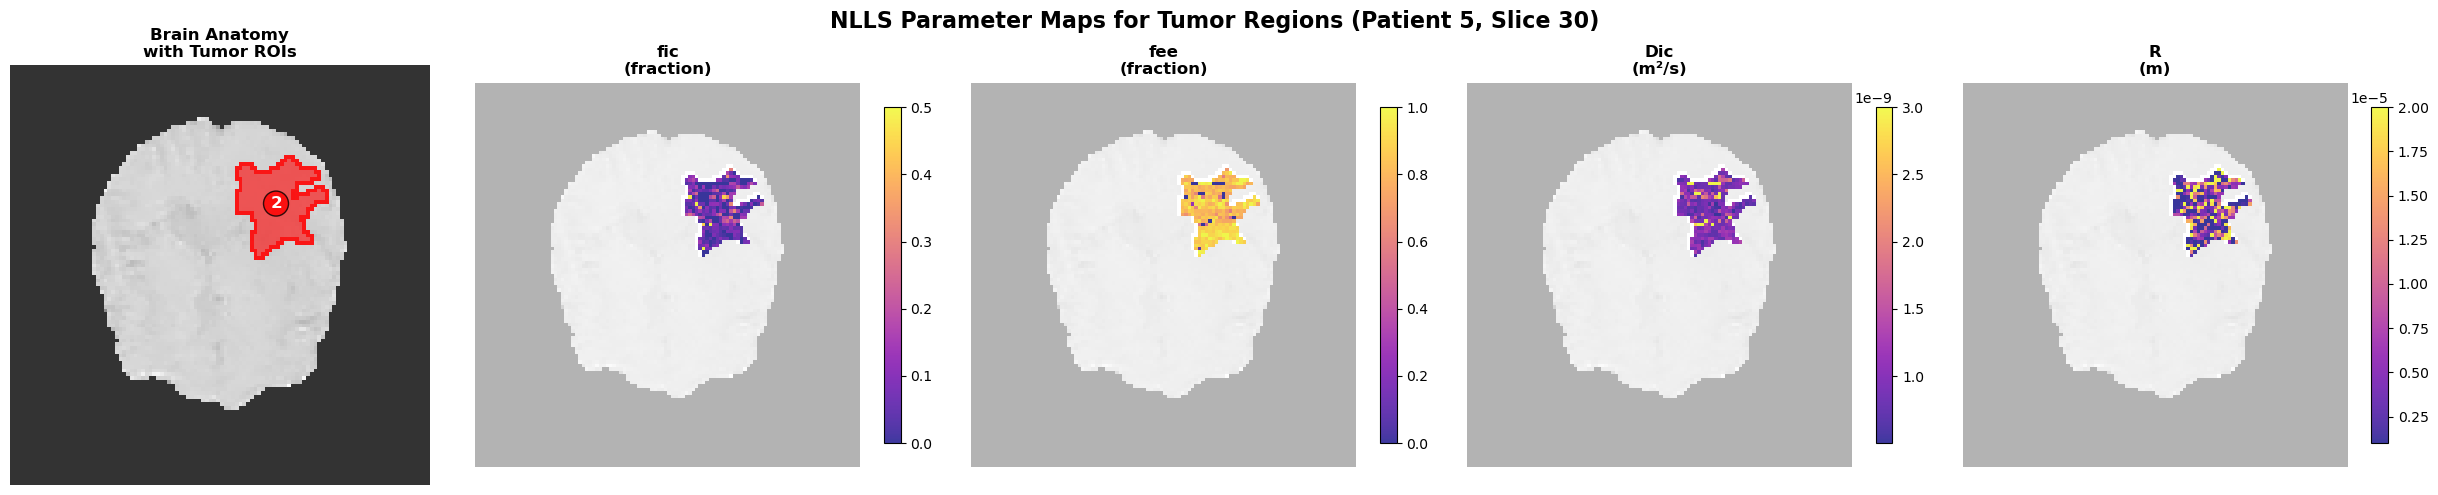


NLLS Parameter Statistics for Tumor Regions in Central Slice 30:
fic:  313 voxels | Mean=  0.0826 ±   0.1033 | Range=[  0.0000,   0.9083]
fee:  313 voxels | Mean=  0.8093 ±   0.2037 | Range=[  0.0000,   1.0000]
Dic:  313 voxels | Mean=1.10e-09 ± 5.33e-10 | Range=[4.11e-10, 3.00e-09]
R  :  313 voxels | Mean=7.49e-06 ± 6.88e-06 | Range=[1.00e-06, 2.00e-05]

Complete NLLS Tumor Analysis Summary:
• Total tumor voxels in volume: 6,204
• NLLS fitted voxels: 50,501
• Coverage: 814.0% of tumor voxels
• Central slice tumor voxels: 313

Overall NLLS Parameter Ranges (All 50,501 tumor voxels):
  fic: Mean=  0.1214, Range=[  0.0000,   1.0000]
  fee: Mean=  0.8132, Range=[  0.0000,   1.0000]
  Dic: Mean=1.10e-09, Range=[1.00e-11, 3.00e-09]
  R: Mean=8.56e-06, Range=[1.00e-06, 2.00e-05]

NLLS tumor parameter visualization completed.


In [34]:
# NLLS PARAMETER MAP VISUALIZATION FOR TUMOR REGIONS
print("CREATING NLLS PARAMETER MAP VISUALIZATION FOR TUMOR REGIONS")
print("=" * 80)

import pandas as pd
from scipy import ndimage
from matplotlib.colors import ListedColormap

# Load ROI data if not already loaded
try:
    Patient5_roi_data
except NameError:
    Patient5_roi_path = r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient05\Patient05_ROIs_to_DWI_small.nii.gz'
    Patient5_roi_img = nib.load(Patient5_roi_path)
    Patient5_roi_data = Patient5_roi_img.get_fdata()
    print("Loaded ROI data")

# Debug: Check data dimensions
print("=== Data Dimension Analysis ===")
print(f"Brain data shape: {Patient5_data.shape}")
print(f"ROI data shape: {Patient5_roi_data.shape}")
print(f"NLLS parameter array length: {len(fic_values)}")

# Find tumor voxels (ROI values 1 and 2)
tumor_mask_3d = (Patient5_roi_data == 1) | (Patient5_roi_data == 2)
tumor_voxel_count = np.sum(tumor_mask_3d)
print(f"Total tumor voxels (ROI 1+2): {tumor_voxel_count}")
print(f"NLLS fitted voxels: {len(fic_values)}")

# Get central slice
central_slice = Patient5_data.shape[2] // 2
brain_slice = Patient5_data[:, :, central_slice, 0].T

# Enhance brain contrast
brain_norm = (brain_slice - brain_slice.min()) / (brain_slice.max() - brain_slice.min() + 1e-8)
brain_enhanced = np.power(brain_norm, 0.6)

# Create parameter maps by mapping NLLS results back to tumor regions
H, W, D = Patient5_data.shape[:3]
nlls_param_maps = {}
compare_params = ['fic', 'fee', 'Dic', 'R']

# Initialize parameter maps with NaN
for param_name in compare_params:
    nlls_param_maps[param_name] = np.full((H, W), np.nan)

# Map NLLS parameters to tumor voxels in the central slice
tumor_slice_mask = tumor_mask_3d[:, :, central_slice].T
tumor_coords_slice = np.where(tumor_slice_mask)

if len(tumor_coords_slice[0]) > 0:
    print(f"Tumor voxels in central slice {central_slice}: {len(tumor_coords_slice[0])}")
    
    # Get 3D coordinates of all tumor voxels
    tumor_coords_3d = np.where(tumor_mask_3d)
    
    # Find which tumor voxels are in the central slice
    slice_indices = tumor_coords_3d[2] == central_slice
    n_slice_voxels = np.sum(slice_indices)
    
    if n_slice_voxels > 0 and n_slice_voxels <= len(fic_values):
        print(f"Mapping {n_slice_voxels} NLLS parameters to central slice tumor voxels")
        
        # Get the first n_slice_voxels from NLLS results (assuming same order)
        for i, param_name in enumerate(compare_params):
            param_data = parameters[param_name][:n_slice_voxels]
            
            # Map to slice coordinates
            y_coords = tumor_coords_slice[0][:n_slice_voxels]
            x_coords = tumor_coords_slice[1][:n_slice_voxels]
            
            for j in range(n_slice_voxels):
                nlls_param_maps[param_name][y_coords[j], x_coords[j]] = param_data[j]

# Get tumor regions for overlay
roi_slice = Patient5_roi_data[:, :, central_slice].T
tumor_regions = {}
for roi_val in [1, 2]:
    tumor_mask = roi_slice == roi_val
    if np.any(tumor_mask):
        tumor_regions[f'Tumor_{roi_val}'] = tumor_mask

# Create visualization with proper parameter maps
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
fig.suptitle(f'NLLS Parameter Maps for Tumor Regions (Patient 5, Slice {central_slice})', 
             fontsize=16, fontweight='bold')

# Brain anatomy with tumor overlay (first subplot)
ax = axes[0]
ax.imshow(brain_enhanced, cmap='gray', vmin=0, vmax=1, alpha=0.8)

# Overlay tumor regions
tumor_colors = ['red', 'orange']
for i, (tumor_name, tumor_mask) in enumerate(tumor_regions.items()):
    if np.any(tumor_mask):
        # Create tumor boundary
        dilated = ndimage.binary_dilation(tumor_mask, structure=np.ones((3,3)))
        boundary = dilated & ~tumor_mask
        
        # Show tumor region
        tumor_overlay = np.ma.masked_where(~tumor_mask, tumor_mask)
        boundary_overlay = np.ma.masked_where(~boundary, boundary)
        
        ax.imshow(tumor_overlay, cmap=ListedColormap([tumor_colors[i]]), 
                 alpha=0.6, vmin=0, vmax=1)
        ax.imshow(boundary_overlay, cmap=ListedColormap([tumor_colors[i]]), 
                 alpha=0.9, vmin=0, vmax=1)
        
        # Add tumor labels
        coords = np.where(tumor_mask)
        if len(coords[0]) > 0:
            centroid_y, centroid_x = coords[0].mean(), coords[1].mean()
            ax.text(centroid_x, centroid_y, tumor_name.split('_')[1], 
                   color='white', fontsize=12, fontweight='bold', 
                   ha='center', va='center',
                   bbox=dict(boxstyle='circle', facecolor=tumor_colors[i], alpha=0.8))

ax.set_title('Brain Anatomy\nwith Tumor ROIs', fontweight='bold')
ax.axis('off')

# Parameter maps (remaining subplots)
for j, param_name in enumerate(compare_params):
    ax = axes[j + 1]
    
    # Show brain anatomy as background
    ax.imshow(brain_enhanced, cmap='gray', alpha=0.3, vmin=0, vmax=1)
    
    # Overlay parameter map
    param_map = nlls_param_maps[param_name]
    
    # Set color range based on valid values
    valid_values = param_map[~np.isnan(param_map)]
    if len(valid_values) > 0:
        if param_name == 'fic':
            vmin, vmax = 0, 0.5  # Constrain fic to maximum of 0.5
        elif param_name == 'fee':
            vmin, vmax = 0, 1
        else:  # Dic, R
            vmin, vmax = np.percentile(valid_values, [1, 99])
        
        # Create masked array to hide NaN values
        param_masked = np.ma.masked_where(np.isnan(param_map), param_map)
        
        im = ax.imshow(param_masked, cmap='plasma', alpha=0.8, vmin=vmin, vmax=vmax)
        
        # Add tumor boundaries
        for tumor_name, tumor_mask in tumor_regions.items():
            if np.any(tumor_mask):
                boundary = ndimage.binary_dilation(tumor_mask, structure=np.ones((2,2))) & ~tumor_mask
                boundary_overlay = np.ma.masked_where(~boundary, boundary)
                ax.imshow(boundary_overlay, cmap=ListedColormap(['white']), 
                         alpha=1.0, vmin=0, vmax=1)
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, shrink=0.8, aspect=20)
        if param_name in ['Dic', 'R']:
            cbar.formatter.set_powerlimits((0, 0))
            cbar.update_ticks()
    else:
        # No valid data for this parameter
        ax.text(0.5, 0.5, f'No {param_name}\ndata in slice', 
                transform=ax.transAxes, ha='center', va='center', 
                fontsize=12, bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.7))
    
    # Set title with units
    if param_name == 'Dic':
        title = f'{param_name}\n(m²/s)'
    elif param_name == 'R':
        title = f'{param_name}\n(m)'
    else:
        title = f'{param_name}\n(fraction)'
    
    ax.set_title(title, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Print parameter statistics for the central slice
print(f"\nNLLS Parameter Statistics for Tumor Regions in Central Slice {central_slice}:")
print("=" * 75)

for param_name in compare_params:
    param_map = nlls_param_maps[param_name]
    valid_values = param_map[~np.isnan(param_map)]
    
    if len(valid_values) > 0:
        mean_val = np.mean(valid_values)
        std_val = np.std(valid_values)
        min_val = np.min(valid_values)
        max_val = np.max(valid_values)
        
        if param_name in ['Dic', 'R']:
            print(f"{param_name:3s}: {len(valid_values):4d} voxels | Mean={mean_val:8.2e} ± {std_val:8.2e} | Range=[{min_val:8.2e}, {max_val:8.2e}]")
        else:
            print(f"{param_name:3s}: {len(valid_values):4d} voxels | Mean={mean_val:8.4f} ± {std_val:8.4f} | Range=[{min_val:8.4f}, {max_val:8.4f}]")
    else:
        print(f"{param_name:3s}: No valid data in this slice")

# Summary statistics for all tumor regions
print(f"\nComplete NLLS Tumor Analysis Summary:")
print("=" * 50)
print(f"• Total tumor voxels in volume: {tumor_voxel_count:,}")
print(f"• NLLS fitted voxels: {len(fic_values):,}")
print(f"• Coverage: {(len(fic_values)/tumor_voxel_count*100):.1f}% of tumor voxels")
print(f"• Central slice tumor voxels: {len(tumor_coords_slice[0]) if len(tumor_coords_slice[0]) > 0 else 0}")

# Overall parameter ranges for all tumor voxels
print(f"\nOverall NLLS Parameter Ranges (All {len(fic_values):,} tumor voxels):")
for param_name in compare_params:
    param_data = parameters[param_name]
    non_zero_data = param_data[param_data > 0]
    
    if len(non_zero_data) > 0:
        mean_val = np.mean(non_zero_data)
        if param_name in ['Dic', 'R']:
            print(f"  {param_name}: Mean={mean_val:8.2e}, Range=[{np.min(non_zero_data):8.2e}, {np.max(non_zero_data):8.2e}]")
        else:
            print(f"  {param_name}: Mean={mean_val:8.4f}, Range=[{np.min(non_zero_data):8.4f}, {np.max(non_zero_data):8.4f}]")

print(f"\nNLLS tumor parameter visualization completed.")

CREATING NLLS PARAMETER MAP VISUALIZATION (Multi-Model Comparison Style)
Patient selected for NLLS visualization: Patient05
Parameters to visualize: ['fic', 'fee', 'Dic', 'R']
Central slice: 30
Brain slice shape: (112, 112)
Total tumor voxels: 6204
NLLS fitted voxels: 50501
Tumor voxels in central slice: 313
Mapping 313 NLLS parameters to central slice
NLLS Dic range: [5.02e-10, 3.00e-09]
NLLS R   range: [1.00e-06, 2.00e-05]


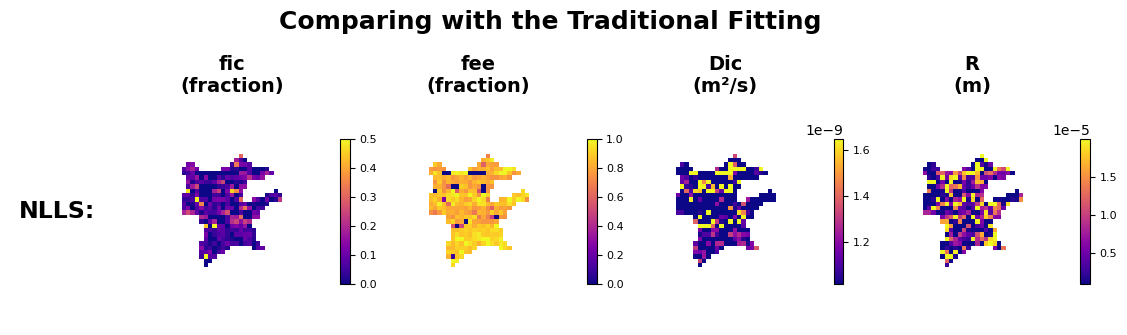


NLLS Parameter Statistics Summary:
Method: Non-Linear Least Squares
Model: AstroSticks-dvZeppelin-Sphere
Patient: Patient05
Central slice: 30
Tumor voxels in slice: 313
fic:  313 voxels | Mean=  0.0826 ±   0.1033
fee:  313 voxels | Mean=  0.8093 ±   0.2037
Dic:  313 voxels | Mean=1.10e-09 ± 5.33e-10
R  :  313 voxels | Mean=7.49e-06 ± 6.88e-06
NLLS parameter map visualization completed.


In [48]:
# NLLS PARAMETER MAP VISUALIZATION (Multi-Model Comparison Style)
import os, pickle, yaml
import numpy as np
import torch
import matplotlib.pyplot as plt
from functools import lru_cache
from importlib import import_module
from scipy import ndimage
from matplotlib.colors import ListedColormap

print("CREATING NLLS PARAMETER MAP VISUALIZATION (Multi-Model Comparison Style)")
print("=" * 90)

# -----------------------
# Config
# -----------------------
patient_of_interest = 'Patient05'  # NLLS data for Patient 5
print(f"Patient selected for NLLS visualization: {patient_of_interest}")

# NLLS configuration
nlls_spec = {"name": "NLLS:", "method": "Non-Linear Least Squares", "model": "AstroSticks-dvZeppelin-Sphere"}

# parameter names (explicit, consistent with multi-model format)
param_names = ['fic', 'fee', 'Dic', 'R', 'Dpar', 'Dtra', 'theta', 'phi']
compare_params = ['fic', 'fee', 'Dic', 'R']
param_indices = {p: i for i, p in enumerate(param_names)}

print(f"Parameters to visualize: {compare_params}")

# -----------------------
# NLLS Data preparation
# -----------------------
# Load ROI data if not already loaded
try:
    Patient5_roi_data
except NameError:
    Patient5_roi_path = r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient05\Patient05_ROIs_to_DWI_small.nii.gz'
    Patient5_roi_img = nib.load(Patient5_roi_path)
    Patient5_roi_data = Patient5_roi_img.get_fdata()
    print("Loaded ROI data")

# Brain data
brain_data_interest = Patient5_data
central_slice = brain_data_interest.shape[2] // 2
brain_slice = brain_data_interest[:, :, central_slice, 0].T
brain_norm = (brain_slice - brain_slice.min()) / (brain_slice.max() - brain_slice.min() + 1e-8)
brain_enhanced = np.power(brain_norm, 0.6)

print(f"Central slice: {central_slice}")
print(f"Brain slice shape: {brain_slice.shape}")

# Find tumor regions
tumor_mask_3d = (Patient5_roi_data == 1) | (Patient5_roi_data == 2)
tumor_voxel_count = np.sum(tumor_mask_3d)
print(f"Total tumor voxels: {tumor_voxel_count}")
print(f"NLLS fitted voxels: {len(fic_values)}")

# Tumor slice data preparation
tumor_slice_mask = tumor_mask_3d[:, :, central_slice].T
tumor_coords_slice = np.where(tumor_slice_mask)

slice_data = {}
if len(tumor_coords_slice[0]) > 0:
    # Get 3D coordinates of all tumor voxels
    tumor_coords_3d = np.where(tumor_mask_3d)
    slice_indices = tumor_coords_3d[2] == central_slice
    n_slice_voxels = np.sum(slice_indices)
    
    if n_slice_voxels > 0:
        print(f"Tumor voxels in central slice: {n_slice_voxels}")
        slice_data['tumor_slice'] = {
            'roi2d': tumor_slice_mask,
            'y': tumor_coords_slice[0][:n_slice_voxels],
            'x': tumor_coords_slice[1][:n_slice_voxels],
            'n_voxels': n_slice_voxels
        }

if not slice_data:
    print("Warning: No tumor voxels found in central slice")

# -----------------------
# NLLS Parameter Maps
# -----------------------
H, W = brain_slice.shape

# Initialize NLLS parameter maps
nlls_param_maps = {p: np.full((H, W), np.nan, dtype=np.float32) for p in compare_params}

# Map NLLS parameters to tumor voxels in the central slice
if slice_data:
    sdata = slice_data['tumor_slice']
    n_voxels = min(sdata['n_voxels'], len(fic_values))
    
    if n_voxels > 0:
        print(f"Mapping {n_voxels} NLLS parameters to central slice")
        
        # Map parameters to slice coordinates
        y, x = sdata['y'][:n_voxels], sdata['x'][:n_voxels]
        
        for p in compare_params:
            param_data = parameters[p][:n_voxels]
            nlls_param_maps[p][y, x] = param_data

# Robust global ranges for Dic and R (consistent with multi-model approach)
def robust_range(param_map, lo=1, hi=99):
    """Return robust vmin/vmax for a parameter map."""
    valid_data = param_map[~np.isnan(param_map)]
    if valid_data.size == 0:
        return (0.0, 1.0)
    lo_v, hi_v = np.nanpercentile(valid_data, [lo, hi])
    if not np.isfinite(lo_v) or not np.isfinite(hi_v) or lo_v == hi_v:
        lo_v, hi_v = float(np.nanmin(valid_data)), float(np.nanmax(valid_data))
    return lo_v, hi_v

dic_vmin, dic_vmax = robust_range(nlls_param_maps['Dic'])
r_vmin, r_vmax = robust_range(nlls_param_maps['R'])
print(f"NLLS Dic range: [{dic_vmin:.2e}, {dic_vmax:.2e}]")
print(f"NLLS R   range: [{r_vmin:.2e}, {r_vmax:.2e}]")

# -----------------------
# Plotting (Multi-Model Comparison Style)
# -----------------------
n_models = 1  # Just NLLS
cols = 1 + len(compare_params)

# Make first column narrow (0.8) and parameter cols equal width (1.8 each)
widths = [0.8] + [1.8] * len(compare_params)

fig, axs = plt.subplots(
    n_models, cols,
    figsize=(2.4 * cols, 3.5 * n_models),  # Increased height to accommodate title
    constrained_layout=False,  # Use manual layout for better control
    gridspec_kw={"width_ratios": widths, "hspace": 0.1, "wspace": 0.2}
)

# Ensure 2D array even for single row
if n_models == 1:
    axs = np.expand_dims(axs, 0)

# Adjust subplot positions for better alignment - much more space at top for title
plt.subplots_adjust(left=0.05, right=0.95, top=0.75, bottom=0.1, wspace=0.25, hspace=0.2)

#fig.suptitle(
#    f'NLLS Parameter Maps (Patient {patient_of_interest}, Slice {central_slice})',
#    fontsize=18, fontweight='bold'
#)
fig.suptitle(
    f'Comparing with the Traditional Fitting',
    fontsize=18, fontweight='bold', y=1  # Position title higher with more space
)
# Precompute boundary overlay for tumor regions
boundary_overlay = np.zeros_like(brain_slice, dtype=bool)
if slice_data:
    roi2d = slice_data['tumor_slice']['roi2d']
    if np.any(roi2d):
        b = ndimage.binary_dilation(roi2d, structure=np.ones((2,2))) & ~roi2d
        boundary_overlay = b
boundary_mask = np.ma.masked_where(~boundary_overlay, boundary_overlay)

# Single row for NLLS
i = 0
name = nlls_spec['name']

# Model label cell (first column)
ax_label = axs[i, 0]
ax_label.axis('off')
ax_label.text(
    0.5, 0.5, name,
    transform=ax_label.transAxes,
    fontsize=17, fontweight='bold',
    ha='center', va='center'
)

# Parameter maps (remaining columns)
for j, p in enumerate(compare_params, start=1):
    ax = axs[i, j]
    
    # Parameter map - only show tumor regions
    pm = nlls_param_maps[p]
    
    # Create tumor-only parameter map (mask out non-tumor regions)
    if slice_data:
        tumor_only_pm = np.full_like(pm, np.nan)
        roi2d = slice_data['tumor_slice']['roi2d']
        tumor_only_pm[roi2d] = pm[roi2d]
    else:
        tumor_only_pm = pm
    
    # Set color range
    if p == 'fee':
        vmin, vmax = 0.0, 1.0
    elif p == 'Dic':
        vmin, vmax = 1.02e-09, 1.65e-09
    elif p == 'fic':
        vmin, vmax = 0.0, 0.5
    else:  # 'R'
        vmin, vmax = r_vmin, r_vmax
    
    # Show only tumor parameter map (no brain background)
    im = ax.imshow(np.ma.masked_invalid(tumor_only_pm), cmap='plasma', vmin=vmin, vmax=vmax)
    
    # Add tumor boundaries for better definition
    if slice_data and np.any(boundary_overlay):
        ax.imshow(boundary_mask, cmap=ListedColormap(['white']), alpha=0.8)
    
    ax.set_axis_off()
    
    # Parameter title (only for top row) - centered above the tumor region
    if i == 0:
        if p == 'Dic':
            title = f'{p}\n(m²/s)'
        elif p == 'R':
            title = f'{p}\n(m)'
        else:
            title = f'{p}\n(fraction)'
        ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    
    # Individual colorbar for each subplot - positioned to not interfere with centering
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.08, shrink=0.7, aspect=15)
    if p in ('Dic', 'R'):
        cbar.formatter.set_powerlimits((0,0))
        cbar.update_ticks()
    cbar.ax.tick_params(labelsize=8)
    
    # Ensure the tumor region is centered in the subplot
    # Get the bounding box of the tumor region for better centering
    if slice_data and np.any(roi2d):
        tumor_coords = np.where(roi2d)
        if len(tumor_coords[0]) > 0:
            y_min, y_max = tumor_coords[0].min(), tumor_coords[0].max()
            x_min, x_max = tumor_coords[1].min(), tumor_coords[1].max()
            
            # Add some padding around the tumor region
            padding = 10
            y_min = max(0, y_min - padding)
            y_max = min(brain_slice.shape[0], y_max + padding)
            x_min = max(0, x_min - padding)
            x_max = min(brain_slice.shape[1], x_max + padding)
            
            # Set the view limits to center on tumor region
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_max, y_min)  # Note: y-axis is inverted for images

plt.show()

# -----------------------
# Summary Statistics
# -----------------------
print(f"\nNLLS Parameter Statistics Summary:")
print("=" * 60)
print(f"Method: {nlls_spec['method']}")
print(f"Model: {nlls_spec['model']}")
print(f"Patient: {patient_of_interest}")
print(f"Central slice: {central_slice}")

if slice_data:
    n_slice_voxels = slice_data['tumor_slice']['n_voxels']
    print(f"Tumor voxels in slice: {n_slice_voxels}")
    
    for p in compare_params:
        valid_data = nlls_param_maps[p][~np.isnan(nlls_param_maps[p])]
        if len(valid_data) > 0:
            mean_val = np.mean(valid_data)
            std_val = np.std(valid_data)
            
            if p in ['Dic', 'R']:
                print(f"{p:3s}: {len(valid_data):4d} voxels | Mean={mean_val:8.2e} ± {std_val:8.2e}")
            else:
                print(f"{p:3s}: {len(valid_data):4d} voxels | Mean={mean_val:8.4f} ± {std_val:8.4f}")
        else:
            print(f"{p:3s}: No valid data in slice")
else:
    print("No tumor voxels found in central slice")

print("NLLS parameter map visualization completed.")